In [1]:
import sys

sys.path.append('../../')
from msBO import MultiStateBO
from msBO.objective import BPMvar_minimization

import numpy as np
import matplotlib.pyplot as plt
import torch

sys.path.append('../../../machineIO/')
from machineIO import construct_machineIO, VirtualMachineIO, StatefulOracleEvaluator

seed = 0
np.random.seed(seed)
torch.manual_seed(seed)

# import importlib, msBO  # or from boom import msBO if that's your import
# importlib.reload(msBO)

Failed to import 'phantasy'


In [2]:
n_init = 16
n_each = 4
beta = 4

In [3]:
n_control = 4
n_bpm = 3
n_monitor = n_bpm*2
n_task = n_bpm+1
n_state = 3
n_state_pvs = 1

control_CSETs = [f'PSC{i}:I_CSET' for i in range(n_control)]
control_RDs  = [f'PSC{i}:I_RD' for i in range(n_control)]
control_tols = [0.01]*len(control_CSETs)
control_min  = [ 0.0]*len(control_CSETs)
control_max  = [ 1.0]*len(control_CSETs)
bpm_xRDs     = [f'BPM{i}:XPOS_RD' for i in range(n_bpm)]
bpm_magRDs   = [f'BPM{i}:MAG_RD' for i in range(n_bpm)]
monitor_RDs  = bpm_xRDs + bpm_magRDs
state_CSETs  = [f'CSS:POS{i}_CSET' for i in range(n_state_pvs)]
state_RDs    = [f'CSS:POS{i}_RD' for i in range(n_state_pvs)]
state_tols   = [0.01]*len(state_CSETs)
state_min    = [0.0]*n_state_pvs
state_max    = [n_state-1]*n_state_pvs
state_key_vals  = {f'state{s}':[float(s)]*n_state_pvs for s in range(n_state)}
oracle_key_names = {'x':control_RDs,
                    'y':bpm_xRDs + ['BPM:MAG_min_ratio']}
states = list(state_key_vals.keys())

In [4]:
vmIO = VirtualMachineIO(
    control_CSETs = control_CSETs + state_CSETs,
    control_RDs = control_RDs + state_RDs,
    monitor_RDs = monitor_RDs,
    control_min = control_min + state_min,
    control_max = control_max + state_max,
    monitor_min = [-5.0]*n_bpm + [0.8]*n_bpm,
    monitor_max = [ 5.0]*n_bpm + [1.0]*n_bpm,
    complexity  = 128,
)

In [5]:
x0 = np.random.rand(len(control_CSETs))*(np.asarray(control_max) - np.asarray(control_min)) + np.asarray(control_min)
print("x0",x0)
BPM_MAGs_ref = {}
for s,v in state_key_vals.items():
    _ = vmIO.ensure_set(vmIO.control_CSETs, vmIO.control_RDs, np.concatenate([x0,v]), control_tols + state_tols)
    y = vmIO.fetch_data(bpm_magRDs).mean().values
    BPM_MAGs_ref[s] = y
BPM_MAGs_ref

x0 [0.09959812 0.48057581 0.06757783 0.49631831]


{'state0': array([0.90751853, 0.95287074, 0.84484666]),
 'state1': array([0.91390609, 0.94921399, 0.81638342]),
 'state2': array([0.94394773, 0.85790276, 0.88384239])}

In [6]:
def BPM_MAG_obj(df,s):
    df['BPM:MAG_min_ratio'] = (df[bpm_magRDs].values/BPM_MAGs_ref[s][None,:]).min()
    return df

In [7]:
oracleEvaluator = StatefulOracleEvaluator(
    vmIO,
    control_CSETs= control_CSETs,
    control_RDs  = control_RDs,
    control_tols = control_tols,
    state_CSETs  = state_CSETs,
    state_RDs    = state_RDs,
    state_tols   = state_tols,
    state_key_vals = state_key_vals,
    oracle_key_names = oracle_key_names,
    monitor_RDs  = monitor_RDs,
    state_df_manipulators = [BPM_MAG_obj],
)

In [8]:
composite_objective_function = BPMvar_minimization(S=n_state, J=n_task)

In [9]:
acq_type = 'EI'
fix_acq_state = False
local_optimization=False

np.random.seed(seed)
torch.manual_seed(seed)
oracleEvaluator(x=x0,s=states[0])

msbo = MultiStateBO(
    states = states,
    tasks  = oracle_key_names['y'], 
    control_min = control_min,
    control_max = control_max,
    multistate_oracle_evaluator = oracleEvaluator,
    composite_objective_function = composite_objective_function,
    local_bound_size = 0.1*(np.asarray(control_max) - np.asarray(control_min))
    )
msbo.init(n_init=n_init, local_optimization=local_optimization)

for s in states[::-1]:
    for i in range(n_each):
        msbo.step(s=s, local_optimization=local_optimization, acq_type=acq_type, fix_acq_state = fix_acq_state, beta=beta)
for s in states:
    for i in range(n_each-1):
        msbo.step(s=s, local_optimization=local_optimization, acq_type=acq_type, fix_acq_state = fix_acq_state, beta=beta)
for s in states:
    for i in range(n_each-2):
        msbo.step(s=s, local_optimization=local_optimization, acq_type=acq_type, fix_acq_state = fix_acq_state, beta=beta)
for s in states[::-1]:
    for i in range(n_each-3):
        msbo.step(s=s, local_optimization=local_optimization, acq_type=acq_type, fix_acq_state = fix_acq_state, beta=beta)
              
iters, means, stds = msbo.virtual_composite_history()

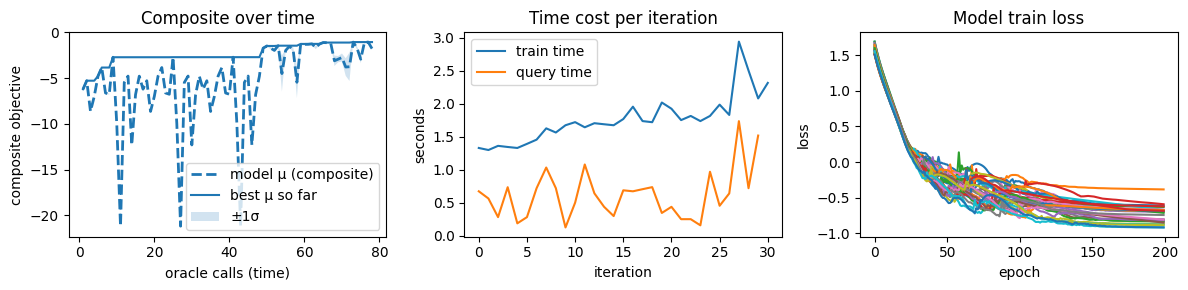

In [10]:
fig,ax, mean = msbo.plot_composite_objective()

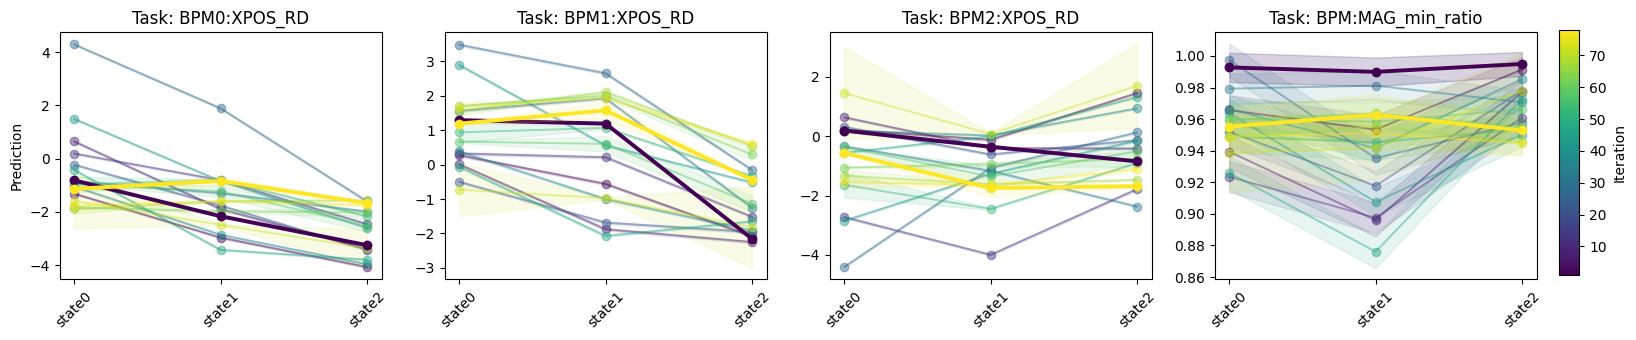

In [11]:
fig, axes = msbo.plot_state_predictions_history()
plt.show()

In [12]:
fig,ax = msbo.plot_acq_loss_history()

No torch acquisition loss history found.
